In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.dpi'] = 60

In [2]:
%run -i helpers.py

# Model Output Statistics for the Lorenz-96 model

## Lorenz-96 Model as Nature

 The Lorenz-96 model is a system of ordinary differential equations (ODEs) for $40$ variables with an external forcing term $F$

$$ \frac{dx_j}{dt} = ( x_{j+1} - x_{j-2} ) x_{j-1} - x_j + F $$

Let's have a look at solutions to the above model. We set the parameters of the sytsem as $F = 8$, $dt = 0.05$, with normally distributed random initial data.

In [3]:
N=40; F=8;
initial_data=np.random.normal(0.25*F,0.5*F,N)

We solve the system with the default setup, which is N=40, dt=0.05, days=90. Each time step corresponds to 6 hours, so a 90 day-period requires 360 time steps. 

In [4]:
Transient=Lorenz()
Transient.solve(days=90,init_data=initial_data)
#anim=Transient.animate()

We construct a reference solution which we call nature. This will be a 5-year solution of the Lorenz system. The default parameters for the Lorenz system are the ones we chose above, so we only need to set the number of days. We use the last time step of the transient solution as initial data for the nature solution.

In [5]:
# Nature reference solution for 5 years and 5 days (the additional five days are for the forecasting system) 
total_days = 5*360; forecast_days = 5
Nature=Lorenz()
Nature.solve(days=total_days+forecast_days, init_data=Transient.sol[-1])

## Forecasts

Biases

In [25]:
pert=0.1
# Constant perturbation:
f_const=lambda t: (F+pert)*np.ones(N)
# Spatial variation, constant in time
forcing=8+np.random.normal(0,pert,N)
f_spat=lambda t: forcing
# Random. Perturbation is increased to have comparable forecast errors
f_random=lambda t: F+np.random.normal(0,6*pert,N)

We setup various forecasts based on data on four observing stations at grid points 5, 15, 25, and 35. These forecasts have different biase types. 

- `f_const` adds a constant forcing to all grid points. It acts as a shift in the external forcing term $F$.
- "Noise" adds a normal distributed noise to the grid points with scale given by the noise parameter, centered at zero. "Noise" uses numpy's random.normal function.
- "GridBias" does the same as "Noise" except that the noise is constant at every time step.

In [7]:
stations = np.array([5,15,25,35])
constant =Forecast(Nature=Nature.sol, stations=stations, forecast_days=forecast_days,forcing=f_const)
spatial =Forecast(Nature=Nature.sol, stations=stations, forecast_days=forecast_days,forcing=f_spat)
random =Forecast(Nature=Nature.sol, stations=stations, forecast_days=forecast_days,forcing=f_random)

In [8]:
constant.make_forecast()
spatial.make_forecast()
random.make_forecast()

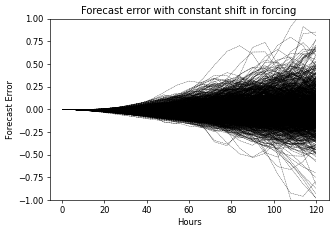

In [22]:
plt.title("Forecast error with constant shift in forcing")
plt.xlabel("Hours")
plt.ylabel("Forecast Error")
plt.ylim(-1,1)
for k in range(constant.nature_days-forecast_days):
    plt.plot(constant.hours, Nature.sol[4*k:4*k+4*forecast_days+1,stations[0]]-\
             constant.station_forecast[k,:,0],'k--',lw=0.4)
plt.savefig("../../docs/static/forecast_error_constant.png")

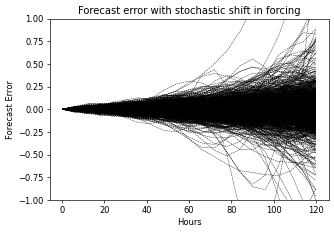

In [27]:
plt.title("Forecast error with stochastic shift in forcing")
plt.xlabel("Hours")
plt.ylabel("Forecast Error")
plt.ylim(-1,1)
for k in range(constant.nature_days-forecast_days):
    plt.plot(random.hours,Nature.sol[4*k:4*k+4*forecast_days+1,stations[0]]-random.station_forecast[k,:,0],'k--',lw=0.5)
plt.savefig("../../docs/static/forecast_error_random.png")

In [37]:
%time constant.process()
%time noise.process()
%time gridbias.process()

CPU times: user 3.37 s, sys: 37.7 ms, total: 3.41 s
Wall time: 3.43 s
CPU times: user 3.88 s, sys: 78.1 ms, total: 3.96 s
Wall time: 3.93 s
CPU times: user 3.46 s, sys: 44 ms, total: 3.5 s
Wall time: 3.36 s


The figure below compares the uncorrected, biased model forecasts with the corrected MOS forecasts.

<IPython.core.display.Javascript object>


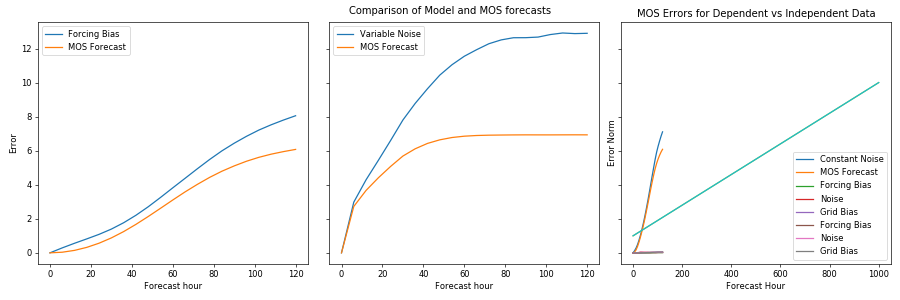

In [41]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,5))
fig.suptitle("Comparison of Model and MOS forecasts")
for ax in axs.flat:
    ax.set(xlabel='Forecast hour', ylabel='Error')
axs[0].plot(constant.hours,constant.errors, label="Forcing Bias")
axs[0].plot(constant.hours,constant.mos_errors, label="MOS Forecast")
axs[0].legend(loc=2)
axs[1].plot(noise.hours,noise.errors, label="Variable Noise")
axs[1].plot(noise.hours,noise.mos_errors, label="MOS Forecast")
axs[1].legend(loc=2)
axs[2].plot(gridbias.hours,gridbias.errors, label="Constant Noise")
axs[2].plot(gridbias.hours,gridbias.mos_errors, label="MOS Forecast")
axs[2].legend(loc=2)
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("figs/ModelMOS.pdf")

The MOS-forecast error improvement over biased forecasts grows with forecast hour. The difference is largest for the variable noise where a Gaussian distributed noise is added at each time step. In that case, MOS forecast reaches climatology whereas the biased forecasts keep giving wrong forecasts with no knowledge of climatology.

### Dependent and independent MOS forecasts

In [42]:
def dep_indep(model):
    model.make_forecast()
    model.make_mos_forecast()
    model.error_norms()
    independent_mos_errors=model.mos_errors.copy()
    model.regression_pars()
    model.make_mos_forecast()
    model.error_norms()
    dependent_mos_errors=model.mos_errors
    return independent_mos_errors-dependent_mos_errors

In [43]:
Nature.solve(init_data=Nature.sol[-1])

In [44]:
constant.Truth = Nature.sol
noise.Truth = Nature.sol
gridbias.Truth = Nature.sol

In [45]:
fb_comp = dep_indep(constant)
ns_comp = dep_indep(noise)
gb_comp = dep_indep(gridbias)

<IPython.core.display.Javascript object>


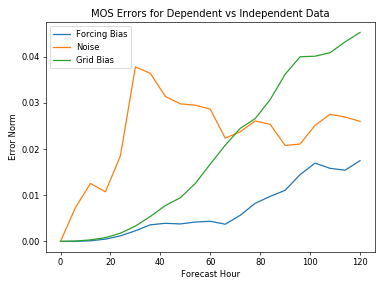

In [51]:
plt.plot(constant.hours,fb_comp, label="Forcing Bias")
plt.plot(noise.hours,ns_comp, label="Noise")
plt.plot(gridbias.hours,gb_comp, label="Grid Bias")
plt.xlabel("Forecast Hour")
plt.ylabel("Error Norm")
plt.title("MOS Errors for Dependent vs Independent Data")
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig("figs/DepIndep.pdf")